# Introduction & prerequisites

each time this notebook is run, it will predict
weather for all open resorts which currently have weather data uploaded
in the "ski_weather" hopsworks feature group. It will predict the same
amount of future years as the ski resort has historical weather data

## Install package requirements and import dependencies

In [1]:
!pip install -r ../requirements.txt --quiet

import numpy as np
from dotenv import load_dotenv
import pandas as pd
from datetime import date
import subprocess
from io import StringIO
import hopsworks
from datetime import date
import great_expectations as ge
import json
import copy
import time
import statistics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    DotProduct, ExpSineSquared, Matern, WhiteKernel
)
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Load environment variables from the .env file

In [2]:
load_dotenv()

True

In [3]:
min_year = 1940
max_year = date.today().year - 1

## Connect to hopsworks

In [4]:
project = hopsworks.login()

2026-01-05 18:35:15,295 INFO: Initializing external client
2026-01-05 18:35:15,296 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 18:35:16,560 WARNING: UserWarning: The installed hopsworks client version 4.3.1 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-05 18:35:17,704 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271967


In [5]:
fs = project.get_feature_store()

## Define expectation suites for predicted ski weather

In [6]:


id_expectation = ge.core.ExpectationConfiguration(
    expectation_type="expect_column_min_to_be_between",
    kwargs={
        "column":"ski_resort_id",
        "min_value":0,
        "max_value": 1000000000
    }
)

temperature_expectation = ge.core.ExpectationConfiguration(
    expectation_type="expect_column_min_to_be_between",
    kwargs={
        "column":"mean_week_temperature",
        "min_value":-100,
        "max_value":20
    }
)

temperature_expectation_2 = ge.core.ExpectationConfiguration(
    expectation_type="expect_column_max_to_be_between",
    kwargs={
        "column":"mean_week_temperature",
        "min_value":0,
        "max_value":100
    }
)

In [7]:
ski_weather_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="ski_weather_expectation_suite"
)
ski_weather_expectation_suite.add_expectation(id_expectation)
ski_weather_expectation_suite.add_expectation(temperature_expectation)
ski_weather_expectation_suite.add_expectation(temperature_expectation_2)

{"expectation_type": "expect_column_max_to_be_between", "kwargs": {"column": "mean_week_temperature", "min_value": 0, "max_value": 100}, "meta": {}}

## Synchronize current ski resort data

In [8]:
current_resorts_fg = fs.get_feature_group(name='current_resorts', version=1)
or_df = current_resorts_fg.read(dataframe_type="pandas")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.49s) 


In [9]:
or_df

,id,name,latitude,longitude
0,1226505097,Torgnon,45.814452,7.554285
1,601135063,Font d'Urle Chaud Clapier,44.910152,5.323491
2,1254287966,Ristolas en Queyras,44.771783,6.960893
3,601115623,Alpe Devero,46.307671,8.252052
4,7752047,San Martino di Castrozza - Passo Rolle,46.268927,11.792439
...,...,...,...,...
834,45409595,Antagnod,45.822300,7.682800
835,1227121146,Gitschenen – Isenthal,46.899355,8.501497
836,601131935,Saint Luc - Chandolin,46.236511,7.625363
837,642545662,Seefeld - Gschwandtkopf,47.317186,11.171586


### get weather for ski resorts

In [10]:
# create/get feature store
ski_weather_fg = fs.get_feature_group(
    name='ski_weather',
    version='1'
)

In [11]:
ski_weather_df = ski_weather_fg.read(dataframe_type="pandas")
ski_weather_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.14s) 


,date,ski_resort_id,closed,mean_week_temperature
0,1968-12-05 00:00:00+00:00,842,True,-14.206722
1,1978-03-05 00:00:00+00:00,273,True,2.645361
2,1962-03-02 00:00:00+00:00,150,True,-11.163786
3,1974-11-04 00:00:00+00:00,146,True,-0.513095
4,1972-01-04 00:00:00+00:00,273,True,-4.874976
...,...,...,...,...
253540,2009-02-04 00:00:00+00:00,296909728,False,-4.529214
253541,2009-03-03 00:00:00+00:00,601115623,False,-3.556429
253542,2009-11-02 00:00:00+00:00,1227308055,False,2.214988
253543,2009-01-03 00:00:00+00:00,1449612770,False,-2.543250


# Weather model

## Prepare weather data for weather model

* Filter out all closed resorts
* create t_year column. t_year is used by weather model to measure time

In [12]:
ski_weather_df = ski_weather_df.loc[ski_weather_df["closed"] == False]

In [13]:
def create_t_years(weather_df: pd.DataFrame):
    weather_df["t_years"] = np.float64(weather_df["date"].dt.year - first_year)
    for i in range(0, len(weather_df["date"])):
        week = int(weather_df.iloc[i]["date"].day)
        month = int(weather_df.iloc[i]["date"].month)
        t_month = (month-1)/12
        t_week = week/(12*5)
        weather_df.iloc[i, len(weather_df.columns)-1] += t_month + t_week
    return weather_df

In [14]:
ski_weather_df = ski_weather_df.sort_values(by=['date'], ascending=False)
last_year = ski_weather_df["date"].iloc[:1].item().year
last_year = np.float64(last_year)

ski_weather_df = ski_weather_df.sort_values(by=['date'], ascending=True)
first_year = ski_weather_df["date"].iloc[:1].item().year
first_year = np.float64(first_year)
ski_weather_df = create_t_years(ski_weather_df)
print(ski_weather_df)

                            date  ski_resort_id  closed  \
218297 1995-01-01 00:00:00+00:00     1227308055   False   
218217 1995-01-01 00:00:00+00:00     1422165435   False   
217313 1995-01-01 00:00:00+00:00     1130708403   False   
217308 1995-01-01 00:00:00+00:00     1449656646   False   
219194 1995-01-01 00:00:00+00:00     1449878541   False   
...                          ...            ...     ...   
216058 2025-12-05 00:00:00+00:00      342008514   False   
216053 2025-12-05 00:00:00+00:00      601236124   False   
216044 2025-12-05 00:00:00+00:00      543864985   False   
215776 2025-12-05 00:00:00+00:00      336062441   False   
216866 2025-12-05 00:00:00+00:00      341907027   False   

        mean_week_temperature    t_years  
218297              -6.848702   0.016667  
218217             -13.102916   0.016667  
217313              -7.666203   0.016667  
217308             -16.018524   0.016667  
219194              -8.842072   0.016667  
...                       ...    

## Weather model inference

For each ski resort fetched with X years of historical weekly weather data, predict the weekly weather data for X years into the future.

In [15]:
resort_weather_dfs = []
future_dfs = []

for ski_resort_id in ski_weather_df["ski_resort_id"].unique():
    # define data
    resort_weather_df = ski_weather_df[ski_weather_df["ski_resort_id"] == ski_resort_id]
    X = resort_weather_df[["t_years"]].to_numpy(dtype=np.float64)
    y = resort_weather_df["mean_week_temperature"].to_numpy(dtype=np.float64)
    

    future_dates = copy.deepcopy(resort_weather_df["date"])
    for di in range(0, len(future_dates.index)):
        this_year = int(future_dates.iloc[di].year + (last_year - first_year + 1))
        this_month = int(future_dates.iloc[di].month)
        this_week = int(future_dates.iloc[di].day)
        this_date = pd.to_datetime(date(this_year,this_month,this_week), utc=True)
        future_dates.iloc[di] = this_date

    t_future = copy.deepcopy(resort_weather_df["t_years"])
    for i in range(0, len(t_future)):
        t_future.iloc[i] = t_future.iloc[i] + (last_year - first_year + 1)

    X_future = t_future.values.reshape(-1, 1)
    
    # define kernel
    kernel = (
        # linear trend kernel
        DotProduct(sigma_0=0.03**2)
        # seasonal kernel
        + 4.0**2 * ExpSineSquared(
            length_scale=4.0,
            periodicity=1.0
        )
        # weather kernel
        + 1.5**2 * Matern(
            length_scale=1/52,
            nu=1.5
        )
        + WhiteKernel(noise_level=0.3**2)
    )

    gp = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        optimizer=None
    )

    # fit kernel to data
    gp.fit(X, y)

    # inference on future values
    mean_temp, std_temp = gp.predict(
        X_future, return_std=True
    )

    d = {'ski_resort_id': ski_resort_id, 'date': future_dates, 'mean_week_temperature': mean_temp}
    future_dfs.append(pd.DataFrame(d))
    resort_weather_dfs.append(resort_weather_df)

## Upload predicted weather data to hopsworks

In [16]:
# create one large pandas dataframe out of all prediction dataframes
pred_ski_weather_df = copy.deepcopy(future_dfs[0])
for i in range(1, len(future_dfs)):
    pred_ski_weather_df = pd.concat([pred_ski_weather_df, future_dfs[i]])

# print out values for debug purposes
printout = 0
for elem in pred_ski_weather_df.iterrows():
    print(elem[1].iloc[0], elem[1].iloc[1], elem[1].iloc[2])
    printout += 1
    if printout >= 100:
        break

1227308055 2026-01-01 00:00:00+00:00 -1.868720760667363
1227308055 2026-01-02 00:00:00+00:00 -0.9080732620837012
1227308055 2026-01-03 00:00:00+00:00 -0.5308952264581859
1227308055 2026-01-04 00:00:00+00:00 -0.35073202075234544
1227308055 2026-01-05 00:00:00+00:00 -0.1732193887470745
1227308055 2026-02-01 00:00:00+00:00 0.06692623203907261
1227308055 2026-02-02 00:00:00+00:00 0.38628106669330464
1227308055 2026-02-03 00:00:00+00:00 0.7854884834159678
1227308055 2026-02-04 00:00:00+00:00 1.25996247864874
1227308055 2026-03-01 00:00:00+00:00 2.4074061185387494
1227308055 2026-03-02 00:00:00+00:00 3.064642143867623
1227308055 2026-03-03 00:00:00+00:00 3.7662774839214834
1227308055 2026-03-04 00:00:00+00:00 4.503537289187898
1227308055 2026-03-05 00:00:00+00:00 5.267571155694949
1227308055 2026-11-01 00:00:00+00:00 5.744403825923671
1227308055 2026-11-02 00:00:00+00:00 4.92398911196032
1227308055 2026-11-03 00:00:00+00:00 4.132021689762943
1227308055 2026-11-04 00:00:00+00:00 3.37905956661

In [43]:
# get feature group and upload to hopsworks
predicted_ski_weather_fg = fs.get_or_create_feature_group(
    name='predicted_ski_weather',
    description='weekly ski resort weather predictions for open resorts',
    version=1,
    primary_key=['ski_resort_id', 'date'],
    expectation_suite=ski_weather_expectation_suite
)
predicted_ski_weather_fg.insert(pred_ski_weather_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1271967/fs/1258570/fg/1880647
2026-01-04 21:30:31,756 INFO: 	3 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/1271967/fs/1258570/fg/1880647


Uploading Dataframe: 100.00% |█| Rows 75200/75200 | Elapsed Time: 00:09 | Remaining Time: 00:0


Launching job: predicted_ski_weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271967/jobs/named/predicted_ski_weather_1_offline_fg_materialization/executions


(Job('predicted_ski_weather_1_offline_fg_materialization', 'SPARK'),
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_max_to_be_between",
         "kwargs": {
           "column": "mean_week_temperature",
           "min_value": 0,
           "max_value": 100
         },
         "meta": {
           "expectationId": 801903
         }
       },
       "result": {
         "observed_value": 11.162913661468409,
         "element_count": 75200,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2026-01-04T08:30:31.000756Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     },
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_

# Inspect predicted weather data using matplotlib

 Take a sample resort prediction and visualize it. To give a form o sanity check that the weather model actually gives sound predictions.

In [17]:
# CHANGE BELOW VARIABLES DEPENDING ON WHICH RESORT ON WHICH DATES YOU WANT TO INSPECT
resort_to_inspect = 23 # affects yearly temperature and weekly temperature graph
inspected_month = 1 # only affects yearly temperature graph
inspected_week = 1 # only affects yearly temperature graph

In [31]:
ski_resort_id = future_dfs[resort_to_inspect].ski_resort_id.values[0]
future_df = future_dfs[resort_to_inspect]
resort_weather_df = resort_weather_dfs[resort_to_inspect]


pf_df = copy.deepcopy(future_df)
for i in range(len(resort_weather_df["date"])):
    new_elem = np.array([[resort_weather_df.iloc[i, 1], resort_weather_df.iloc[i, 0], resort_weather_df.iloc[i, 3]]])
    new_columns = np.array([pf_df.columns[0], pf_df.columns[1], pf_df.columns[2]])
    new_row = pd.DataFrame(data=new_elem, columns=new_columns)
    pf_df = pd.concat([pf_df, new_row])
pf_df = pf_df.sort_values(by=['date'])
pf_df = create_t_years(pf_df)
pf_df

,ski_resort_id,date,mean_week_temperature,t_years
0,13766277,1995-01-01 00:00:00+00:00,-15.931704,0.016667
0,13766277,1995-01-02 00:00:00+00:00,-13.003131,0.033333
0,13766277,1995-01-03 00:00:00+00:00,-10.473369,0.050000
0,13766277,1995-01-04 00:00:00+00:00,-4.557,0.066667
0,13766277,1995-01-05 00:00:00+00:00,-4.545889,0.083333
...,...,...,...,...
215989,13766277,2056-12-01 00:00:00+00:00,3.515269,61.933333
215035,13766277,2056-12-02 00:00:00+00:00,2.950058,61.950000
216241,13766277,2056-12-03 00:00:00+00:00,2.469907,61.966667
216127,13766277,2056-12-04 00:00:00+00:00,2.081126,61.983333


In [32]:
inspected_df = pf_df.loc[pf_df["date"].dt.month == inspected_month]
inspected_df = inspected_df.loc[inspected_df["date"].dt.day == inspected_week]
inspected_arr = np.empty(0, dtype=np.float64)
for elem in inspected_df.iterrows():
    inspected_arr = np.append(inspected_arr, elem[1]["mean_week_temperature"])


<Figure size 640x480 with 0 Axes>

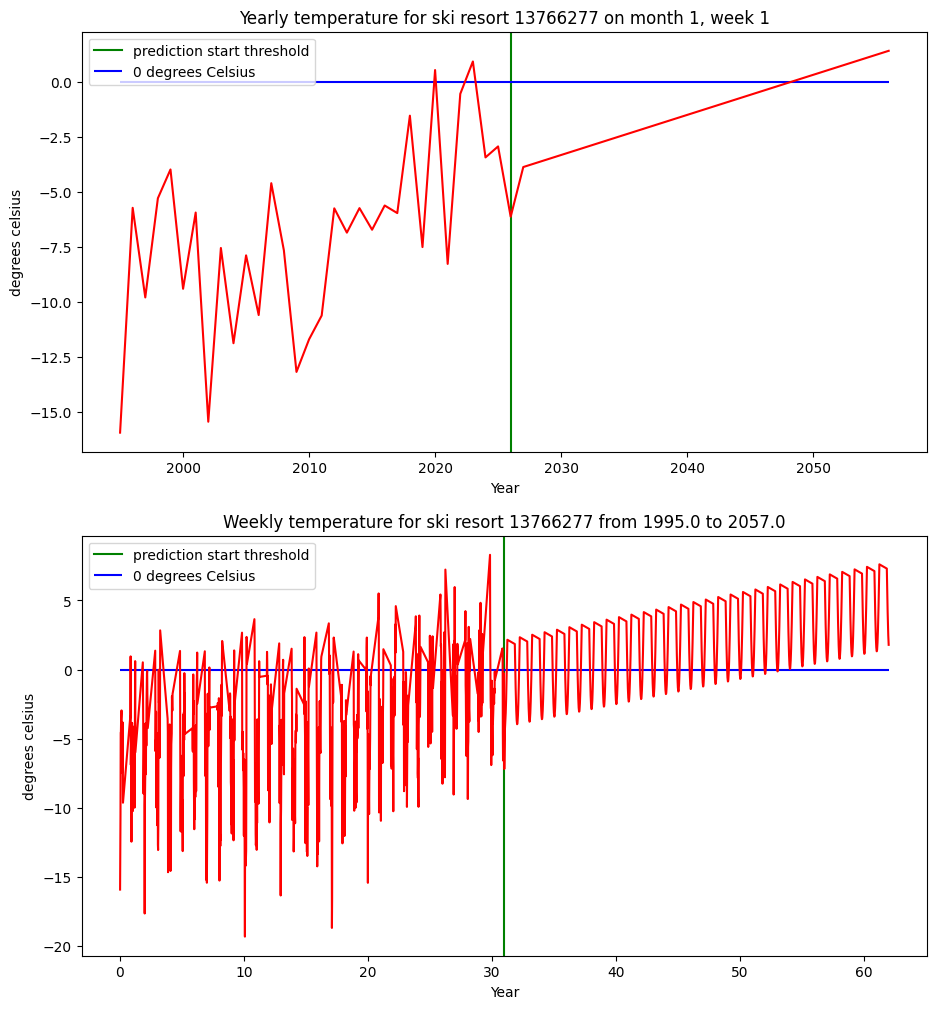

In [39]:
plot_years = np.arange(first_year, first_year+len(inspected_arr))
plot_yearly_date = inspected_arr
plot_t_years = pf_df["t_years"].to_numpy()
plot_weekly = pf_df["mean_week_temperature"].to_numpy()
# Initialize a new figure and set the size
plt.figure(1)
plt.figure(figsize=(24,12))
# Define a subplot structure and choose the first subplot
plt.subplot(221)
plt.xlabel('Year')
plt.ylabel('degrees celsius')
plt.title(f'Yearly temperature for ski resort {ski_resort_id} on month {inspected_month}, week {inspected_week}')
plt.axvline(x = 2026, color = 'g', label='prediction start threshold')
plt.hlines(y=[0], colors=['b'], linestyles=['-'], xmin=plot_years.min(), xmax=plot_years.max(), label='0 degrees Celsius')
plt.legend()
plt.plot(plot_years, plot_yearly_date, 'r')
plt.subplot(223)
plt.axvline(x = 31, color = 'g', label='prediction start threshold')
plt.hlines(y=[0], colors=['b'], linestyles=['-'], xmin=plot_t_years.min(), xmax=plot_t_years.max(), label='0 degrees Celsius')
plt.legend()
plt.xlabel('Year')
plt.ylabel('degrees celsius')
plt.title(f'Weekly temperature for ski resort {ski_resort_id} from {first_year} to {first_year+len(inspected_arr)}')
plt.plot(plot_t_years, plot_weekly, 'r')

plt.show()